<img src="https://www.alura.com.br/artigos/assets/para-que-serve-adobe-illustrator/imagem1.jpg" alt="Imagem1.png" width="300" />


# **Redes Neurais Difusoras: Deep Learning com Pytorch**
---



## **Aula 2 - Fundamentos do Ruído: Intuição Matemática da Difusão**

Na primeira aula, discutimos o surgimento dos modelos generativos, sua relevância no contexto atual da IA e vimos como os modelos de difusão tornaram-se protagonistas em diversas aplicações. Hoje vamos nos aprofundar nos fundamentos estatísticos e conceituais do processo de difusão, abordando a importância do ruído, o crescimento da entropia, a estrutura do manifold dos dados e o papel crítico das cadeias de Markov nesse processo.

> **manifold:**	O lugar(subespaço) onde seus dados reais vivem.

### **O processo físico: entropia e ruído como motor da geração**

Como já discutimos, os modelos de difusão foram inspirados em processos da termodinâmica fora do equilíbrio e fenômenos de movimento browniano. A ideia central, apresentada por [Sohl-Dickstein et al. (2015)](https://arxiv.org/pdf/1503.03585), é que podemos entender os dados como sistemas físicos que, ao longo do tempo, são sujeitos a perturbações aleatórias (ruído térmico), fazendo com que sua entropia aumente gradativamente.

Na prática, começamos com dados altamente estruturados (imagens claras, sons organizados etc.), e a cada passo adicionamos pequenas quantidades de [ruído gaussiano](https://en.wikipedia.org/wiki/Gaussian_noise). Esse processo é iterado por centenas ou milhares de passos até que a estrutura original dos dados é completamente obliterada, a amostra torna-se estatisticamente indistinguível de puro ruído gaussiano $N(0,I)$ (que é uma distribuição máxima entropia para variância fixa).

Esse crescimento da entropia, neste caso não é um efeito colateral, mas sim o objetivo. Pois o intuito dos modelos de difussão é garantir que a entropia diferencial da distribuição aumente até um ponto de máximo desordenamento e com isso,estabelecemos uma condição inicial simples para o processo reverso. Assim, o modelo de geração poderá começar sempre de um ruído conhecido e, gradativamente, reconstruir dados realistas, diminuindo a entropia a cada passo do reverse process.

### **Ruído gaussiano progressivo: o forward process formal**

Matematicamente, o processo de difusão é modelado como uma **cadeia de Markov Gaussiana**, onde cada estado $x_t$ depende apenas do estado imediatamente anterior $x_{t-1}$:

$$
q(x_t \,|\, x_{t-1}) = \mathcal{N}\!\bigl(x_t;\, \sqrt{1 - \beta_t}\, x_{t-1},\, \beta_t I\bigr)
$$

- O termo $\sqrt{1 - \beta_t}\, x_{t-1}$ **preserva parte da estrutura do dado anterior**. Quanto menor $\beta_t$, mais informação original é mantida.
- O termo $\beta_t I$ representa a **covariância do ruído gaussiano isotrópico adicionado** no passo $t$. Quanto maior $\beta_t$, mais ruído é introduzido.

Ao iterar esse processo desde o dado original $x_0$ até o passo $t$, obtemos uma **expressão fechada**:

$$
x_t = \sqrt{\bar{\alpha}_t}\, x_0 + \sqrt{1 - \bar{\alpha}_t}\, \epsilon,
\quad \epsilon \sim \mathcal{N}(0, I)
$$

onde

$$
\bar{\alpha}_t = \prod_{s=1}^t (1 - \beta_s)
$$

- O fator $\sqrt{\bar{\alpha}_t}\, x_0$ indica **quanto da estrutura original permanece** no dado após $t$ passos.
- O termo $\sqrt{1 - \bar{\alpha}_t}\, \epsilon$ mostra **quanto ruído acumulado já substituiu o dado original**.

**À medida que $t$ aumenta:**
- $\bar{\alpha}_t$ diminui, reduzindo a influência de $x_0$.
- $\sqrt{1 - \bar{\alpha}_t}$ cresce, fazendo o ruído dominar.

Assim, no final do processo (para $t$ grande):

$$
x_T \approx \epsilon \sim \mathcal{N}(0, I),
$$

ou seja, o dado foi completamente transformado em **ruído puro**, atingindo um estado de **máxima entropia**.

In [ ]:
# Importando bibliotecas
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Fixando seeds para garantir reprodutibilidade
torch.manual_seed(0)
np.random.seed(0)

# Simulando um manifold 1D no R^1: uma onda senoidal
x0 = torch.sin(torch.linspace(0, 8*np.pi, 1000)).unsqueeze(1)

In [ ]:
T = 5  # número de passos
betas = torch.linspace(0.01, 0.2, T)  # escalas de ruído
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)  # produto acumulado controla a energia do sinal original

In [ ]:
xt_list = [x0]

# Aplica ruído progressivo
for t in range(T):
    noise = torch.randn_like(x0)  # ruído gaussiano ~ N(0,1)
    xt = torch.sqrt(alphas_cumprod[t]) * x0 + torch.sqrt(1 - alphas_cumprod[t]) * noise
    xt_list.append(xt)

In [ ]:
# Função para estimar a entropia diferencial
# Estimando a entropia diferencial via histograma (forma simplificada)
def estimate_entropy(data, bins=50):
    data = data.numpy().flatten()
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    hist += 1e-8  # prevenir log(0)
    ent = -np.sum(hist * np.log(hist)) * (bin_edges[1] - bin_edges[0])
    return ent

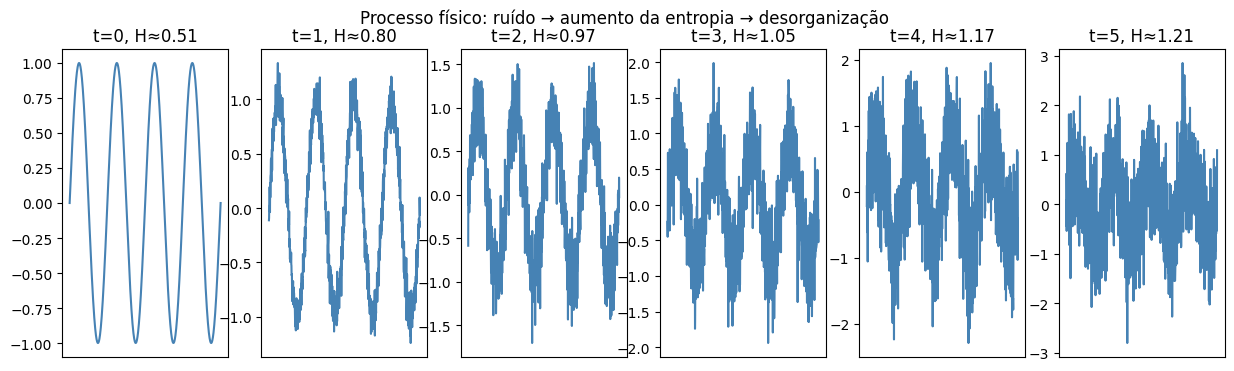

In [ ]:
# Visualização: evolução do processo e entropia
plt.figure(figsize=(15,4))
entropias = []
for i, xt in enumerate(xt_list):
    plt.subplot(1, T+1, i+1)
    plt.plot(xt.numpy(), color='steelblue')
    H = estimate_entropy(xt)
    entropias.append(H)
    plt.title(f"t={i}, H≈{H:.2f}")
    plt.xticks([])
plt.suptitle("Processo físico: ruído → aumento da entropia → desorganização")
plt.show()

### **O processo direto: uma cadeia de Markov**

## Estrutura Markoviana do processo de difusão

Formalizamos o **processo forward** da difusão como uma [cadeia de Markov](https://pt.wikipedia.org/wiki/Cadeias_de_Markov). Em termos simples, uma cadeia de Markov é um **processo estocástico em que o próximo estado depende apenas do estado atual**, e não de toda a história. Isso torna o modelo muito mais simples de analisar e simular, pois não é necessário carregar toda a sequência de estados anteriores, basta conhecer o estado presente.

No caso do processo de difusão, isso significa que a distribuição conjunta ao longo do tempo pode ser fatorada como:

$$
q(x_{1:T} \,|\, x_0) = \prod_{t=1}^T q(x_t \,|\, x_{t-1})
$$

ou seja, cada $x_t$ depende **diretamente apenas de $x_{t-1}$**.

Isso contrasta com um processo que dependeria da trajetória completa, como:

$$
q(x_t \,|\, x_{t-1}, x_{t-2}, ..., x_0) \neq q(x_t \,|\, x_{t-1})
$$

A estrutura **markoviana** é, portanto, fundamental no *forward process* da difusão. Mais adiante, veremos que ela será também essencial para definir o processo **reverso**, que tem o papel de reconstruir amostras a partir do ruído.

#### **Conceituando cadeia de Markov com um exemplo do dia a dia**

Para fixar a intuição, vamos construir uma cadeia de Markov que representa o dia a dia de uma pessoa, transitando entre **Casa, Trabalho, Mercado e Parque**. Cada nó é um estado, e as setas indicam as probabilidades de transitar de um para outro.

In [ ]:
# Importar bibliotecas
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from IPython.display import Image

In [ ]:
# Definir estados e matriz de transição
states = ['Casa', 'Trabalho', 'Mercado', 'Parque']
transition_matrix = np.array([
    [0.1, 0.6, 0.2, 0.1],  # de Casa
    [0.4, 0.2, 0.3, 0.1],  # de Trabalho
    [0.5, 0.1, 0.1, 0.3],  # de Mercado
    [0.3, 0.1, 0.2, 0.4]   # de Parque
])

In [ ]:
# Criar grafo
G = nx.DiGraph()
for i, state_from in enumerate(states):
    for j, state_to in enumerate(states):
        G.add_edge(state_from, state_to, weight=transition_matrix[i, j])

# Labels das arestas com probabilidades
edge_labels = {(sf, st): f"{transition_matrix[i, j]:.1f}"
               for i, sf in enumerate(states) for j, st in enumerate(states)}

# Posições fixas para visualização
pos = {'Casa': (0, 0), 'Trabalho': (2, 1), 'Mercado': (1, -1), 'Parque': (-1, 1)}

In [ ]:
# Função para escolher próximo estado
def next_state(current_state):
    probs = transition_matrix[states.index(current_state)]
    return np.random.choice(states, p=probs)

In [ ]:
# Simular caminhada
np.random.seed(42)
current = 'Casa'
steps = 10
history = [current]
for _ in range(steps):
    current = next_state(current)
    history.append(current)

In [ ]:
history

['Casa',
 np.str_('Trabalho'),
 np.str_('Parque'),
 np.str_('Parque'),
 np.str_('Mercado'),
 np.str_('Casa'),
 np.str_('Trabalho'),
 np.str_('Casa'),
 np.str_('Mercado'),
 np.str_('Mercado'),
 np.str_('Parque')]

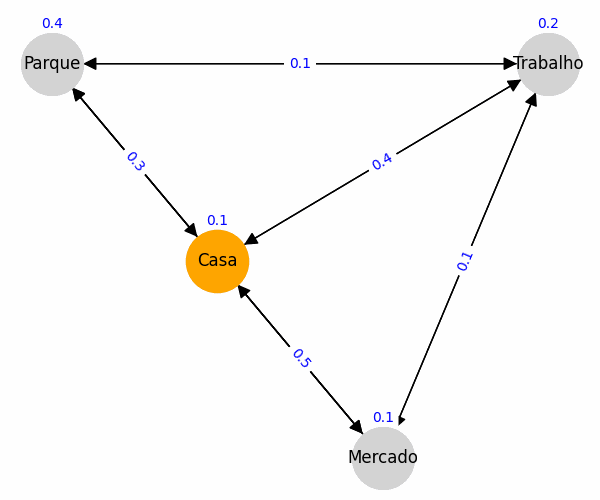

In [ ]:
# Criar GIF mostrando a caminhada
filenames = []
for i, state in enumerate(history):
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=2000, arrowsize=20)
    nx.draw_networkx_nodes(G, pos, nodelist=[state], node_color='orange', node_size=2000)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')
    plt.title(f"Passo {i}: atualmente em {state}")
    fname = f"markov_step_{i}.png"
    plt.savefig(fname)
    plt.close()
    filenames.append(fname)

# Salvar GIF
with imageio.get_writer('markov_chain.gif', format="GIF", duration=200, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

Image(filename='markov_chain.gif')


Esse pequeno experimento deixa claro o princípio Markoviano, onde, próximo local escolhido depende **apenas do local atual e das probabilidades de transição**, não de onde a pessoa esteve antes. Da mesma forma, no **forward process da difusão**, a próxima imagem (um pouco mais ruidosa) depende apenas da imagem atual e do ruído adicionado, não de toda a sequência passada.

### **Cadeias de Markov: estrutura temporal do forward process**

## Forward process como cadeia de Markov Gaussiana

No *forward process* da difusão, o dado vai se tornando cada vez mais incerto ao longo do tempo. Isso é feito através de uma **cadeia de Markov Gaussiana**, o que significa:

- O próximo estado $x_t$ depende **apenas do estado imediatamente anterior $x_{t-1}$**.
- Não importa como chegamos até aqui, basta o estado presente e o novo ruído que será adicionado.

Podemos expressar essa propriedade de memória curta assim:

$$
q(x_t \,|\, x_{t-1}, x_{t-2}, ..., x_0) = q(x_t \,|\, x_{t-1})
$$

Ou seja, dado $x_{t-1}$, o próximo passo $x_t$ não guarda dependência direta dos estados anteriores.

Graças a essa estrutura **Markoviana**, a distribuição conjunta ao longo do tempo se fatoriza de forma muito mais simples:

$$
q(x_{1:T} \,|\, x_0) = \prod_{t=1}^T q(x_t \,|\, x_{t-1})
$$

Isso facilita enormemente o trabalho, porque não precisamos modelar uma dependência completa entre todos os passos anteriores. Assim, o processo fica muito mais leve, tanto do ponto de vista computacional quanto analítico.

- **Computacionalmente**, podemos simular o processo passo a passo, observando apenas o estado atual e adicionando ruído, sem armazenar toda a trajetória.
- **Matematicamente**, isso torna possível definir de forma clara o objetivo de treinamento e, mais tarde, construir o processo reverso, que também terá estrutura Markoviana.

In [ ]:
# Importa bibliotecas
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from scipy.stats import norm

In [ ]:
def beta_schedule(timesteps, schedule='cosine'):
    # Gera a lista de betas que controla a quantidade de ruído em cada passo.

    if schedule=='linear':
        # Beta cresce linearmente do começo ao fim
        return torch.linspace(1e-4, 0.02, timesteps)

    if schedule=='cosine':
        # Beta baseado em curva cosseno, mais suave e popular em difusão
        s = 0.008  # suaviza o início
        steps = torch.arange(timesteps+1, dtype=torch.float32)

        # Calcula alpha_bar acumulado usando cosseno ao longo do tempo
        alphas_cum = torch.cos(((steps/timesteps)+s)/(1+s) * math.pi*0.5) ** 2
        alphas_cum = alphas_cum / alphas_cum[0]  # normaliza para começar em 1

        # Betas saem da razão entre alpha_bar(t) e alpha_bar(t-1)
        betas = 1 - (alphas_cum[1:] / alphas_cum[:-1])

        return betas.clamp(max=0.999)  # limita para não passar de 0.999

In [ ]:
def forward_diffusion(image_array, betas):
    timesteps = len(betas)
    noisy_images = []
    alpha_cumprod = 1.0  # acumula quanto do sinal original resta

    for t in range(timesteps):
        beta_t = betas[t]
        alpha_cumprod *= (1 - beta_t)

        noise = np.random.normal(0, 1, image_array.shape)
        alpha = np.sqrt(np.array(alpha_cumprod))
        sigma = np.sqrt(np.array(1 - alpha_cumprod))
        noisy_image = alpha * image_array + sigma * noise

        noisy_images.append(noisy_image)

    return noisy_images


In [ ]:
# Carregar imagem
url = 'https://tse3.mm.bing.net/th/id/OIP.-SXhM0P_yHJjFvUZs2GUJAHaHa?rs=1&pid=ImgDetMain&o=7&rm=3'
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB').resize((128,128))
image_array = np.array(image) / 255.0

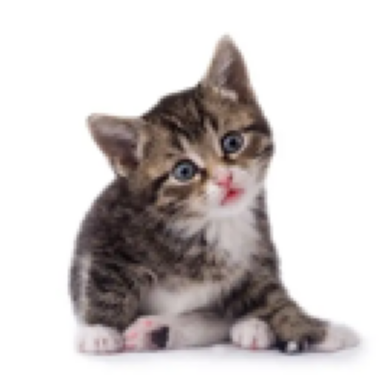

In [ ]:
# Visualizar imagem
plt.imshow(image_array)
plt.axis('off')
plt.show()

In [ ]:
# Gera cronograma de betas (ruído)
timesteps = 1000
betas = beta_schedule(timesteps, schedule='linear')

# Executa difusão
noisy_images = forward_diffusion(image_array, betas)

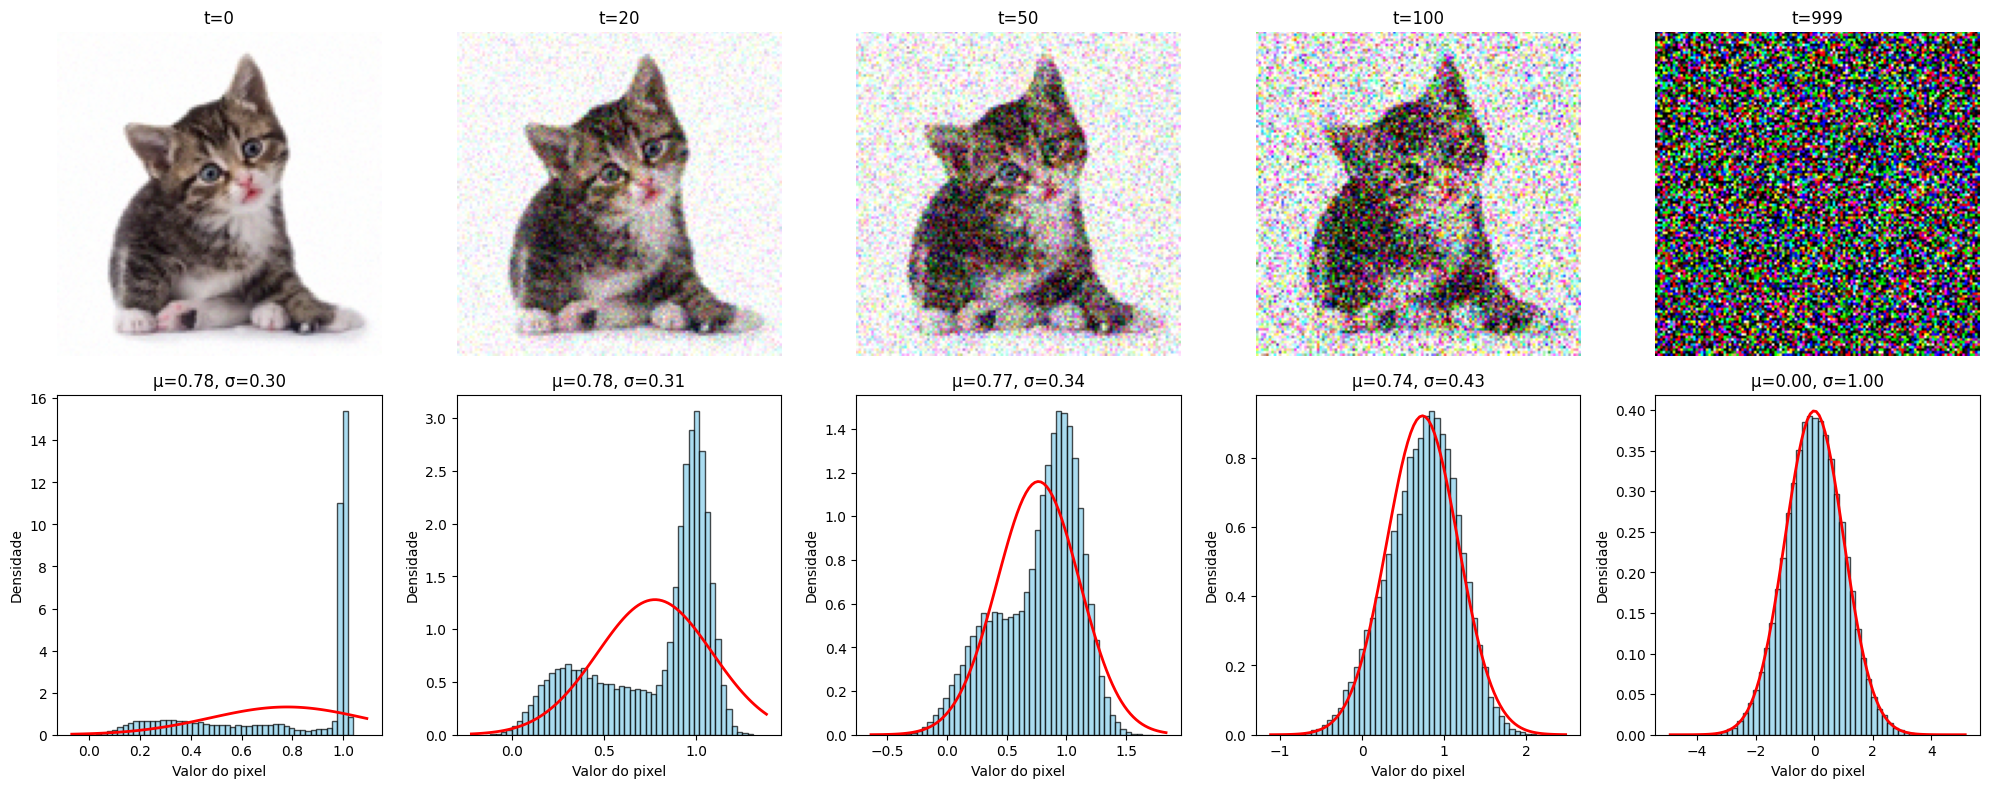

In [ ]:
# Mostra a imagem e histograma em alguns passos
steps = [0, 20, 50, 100, 999]
fig, axes = plt.subplots(2, len(steps), figsize=(4*len(steps), 8))

for idx, step in enumerate(steps):
    img = noisy_images[step]

    # Imagem RGB clipada
    axes[0, idx].imshow(np.clip(img, 0, 1))
    axes[0, idx].axis('off')
    axes[0, idx].set_title(f't={step}')

    # Histograma + ajuste gaussiano
    data = img.flatten()
    count, bins, ignored = axes[1, idx].hist(data, bins=50, density=True,
                                             color='skyblue', edgecolor='black', alpha=0.7)
    mu, std = norm.fit(data)
    xmin, xmax = axes[1, idx].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[1, idx].plot(x, p, 'r', linewidth=2)
    axes[1, idx].set_title(f'μ={mu:.2f}, σ={std:.2f}')
    axes[1, idx].set_xlabel('Valor do pixel')
    axes[1, idx].set_ylabel('Densidade')

plt.tight_layout()
plt.show()

### **A explosão combinatória e o manifold dos dados**

Um ponto conceitual profundo, que motiva toda essa engenharia, é a **natureza do manifold onde os dados residem**. Dados naturais (como imagens, sons ou textos embutidos em vetores) vivem em um espaço de alta dimensão, tipicamente $\mathbb{R}^D$.  

Por exemplo, uma imagem de $26 \times 26$ pixels está em $\mathbb{R}^{676}$.

Mas embora o espaço de todos os possíveis arranjos de pixels seja gigantesco ($256^{676}$ combinações para valores inteiros de 8 bits, ou um contínuo em $[0,1]^{676}$), a imensa maioria desses pontos **não corresponde a dados plausíveis do mundo real**.

Na prática, as imagens naturais se concentram em uma subvariedade (um **manifold**) de dimensão muito menor dentro desse espaço. É como se apenas uma fina casca do espaço total fosse ocupada por imagens realistas.

Esse insight geométrico é fundamental para entender:

- Por que modelos gerativos precisam aprender a **mapear para regiões muito específicas do espaço**.
- Por que é tão difícil amostrar diretamente dados realistas, a maior parte do volume do espaço é composta por combinações de pixels sem sentido.

O processo de difusão explora isso ao espalhar os dados ao longo do espaço (via injeção de ruído), até que se tornem quase indistinguíveis de ruído puro. Depois, aprende-se um processo reverso para gradualmente **voltar ao manifold**, reconstruindo dados plausíveis a partir do caos inicial.


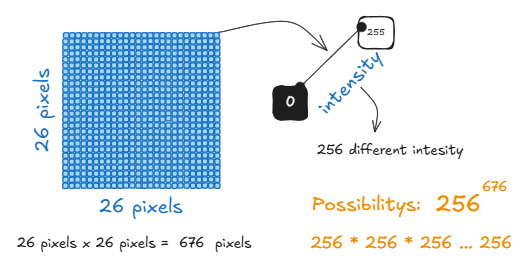

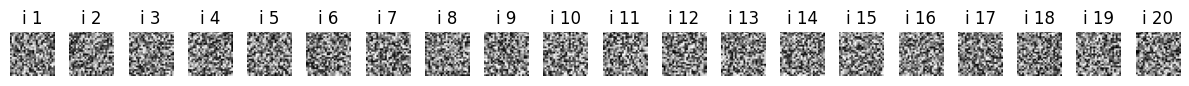

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir as dimensões
width, height = 26, 26

# Criar 20 imagens aleatórias
images = [np.random.randint(0, 256, size=(height, width),
                            dtype=np.uint8) for _ in range(20)]

# Mostrar as imagens em subplots
fig, axes = plt.subplots(1, 20, figsize=(12, 4))

for ax, img, idx in zip(axes, images, range(1, 21)):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.set_title(f'i {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()


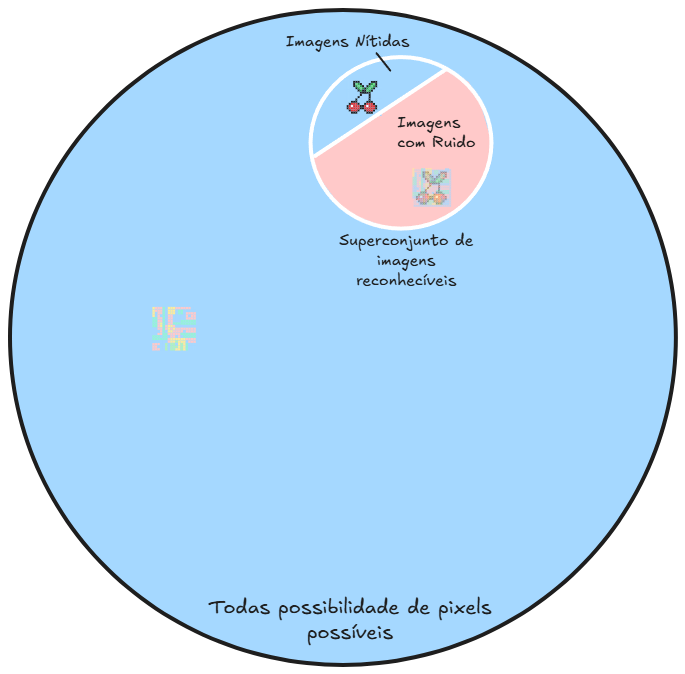

### **A entropia diferencial como testemunha do desordenamento**

Durante o *forward process* da difusão, a **entropia diferencial** cresce monotonicamente:

$$
H(q(x_0)) < H(q(x_t)) < H(q(x_T))
$$

Isso significa:

- $H(q(x_0))$ é a entropia diferencial da **distribuição original dos dados**.  
  (Tipicamente, baixa, pois dados naturais ocupam um manifold concentrado em regiões específicas do espaço.)

- $H(q(x_t))$ é a entropia da distribuição após $t$ passos de adição de ruído.  
  Cada passo adiciona incerteza, espalhando os dados pelo espaço.

- $H(q(x_T))$ é a entropia no final do processo, após $T$ passos.  
  Aqui, a distribuição já se aproximou de uma gaussiana isotrópica de alta entropia.

Ou seja, o processo de difusão **aumenta progressivamente a incerteza (entropia) dos dados**, transformando uma distribuição complexa e estruturada em algo próximo a ruído branco.


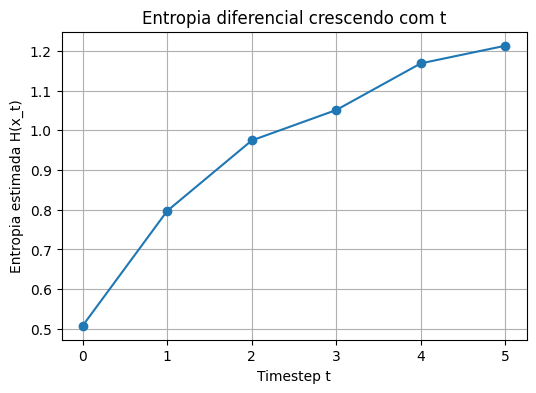

In [ ]:
def estimate_entropy(data, bins=50):
    # Calcula entropia diferencial aproximada via histograma
    data = data.cpu().numpy().flatten()  # converte tensor para array 1D
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    hist += 1e-8  # evita log(0)
    ent = -np.sum(hist * np.log(hist)) * (bin_edges[1] - bin_edges[0])
    return ent


# Calcula a entropia para cada x_t gerado no processo de difusão
entropias = []
for xt in xt_list:
    entropias.append(estimate_entropy(xt))

# Plota como a entropia cresce ao longo do tempo (mais ruído → mais desordem)
plt.figure(figsize=(6,4))
plt.plot(range(T+1), entropias, marker='o')
plt.xlabel("Timestep t")
plt.ylabel("Entropia estimada H(x_t)")
plt.title("Entropia diferencial crescendo com t")
plt.grid()
plt.show()

### **O score function: ponte para o processo reverso**

Depois de entendermos como o *forward process* corrompe o dado até que ele se torne ruído puro, surge a pergunta fundamental:

#### **Como voltamos desse ruído para dados realistas?**

Para isso, precisamos de algo que nos diga **em qual direção no espaço devemos caminhar para que o dado volte a se parecer com amostras do mundo real**, isto é, para que retorne ao manifold dos dados.

## O que é o *score function*?

É aqui que entra o conceito central do **score function**, definido como:

$$
\nabla_x \log p(x)
$$

Ou seja, é o **gradiente do logaritmo da densidade de probabilidade** em cada ponto $x$.

- Esse vetor aponta para a direção onde a densidade de dados cresce mais rapidamente.
- Em outras palavras, indica **o caminho para onde os dados se tornam mais plausíveis**, guiando o ponto $x$ em direção a regiões onde amostras reais são comuns.

Se estivermos em uma região de baixa densidade (pouco provável de conter dados reais), o score nos mostra para onde mover para entrar em regiões mais densas — ou seja, **mais prováveis de conter dados naturais**.


In [ ]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# log densidade de uma gaussiana isotrópica
def log_p(x, y):
    return -0.5 * (x**2 + y**2)

# gradiente do log p(x), aponta para o centro (maior densidade)
def score(x, y):
    return -x, -y

In [ ]:
# Criar grid para plotar a superfície da gaussiana
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp(log_p(X, Y))  # transforma log p(x) em densidade p(x)

steps = 30  # número de passos a simular

In [ ]:
# Começamos no centro (onde estão os dados reais, o "manifold")
point = np.array([0.0, 0.0])
trajectory_forward = [point.copy()]

# A cada passo, adicionamos ruído → aumenta entropia → afasta do manifold
for _ in range(steps):
    noise = np.random.normal(0, 0.5, 2)
    point += noise
    trajectory_forward.append(point.copy())

In [ ]:
trajectory_forward

[array([0., 0.]),
 array([0.88536882, 0.55792771]),
 array([0.93867549, 0.46364716]),
 array([2.14738289, 0.27862138]),
 array([ 2.52465201, -0.01930816]),
 array([ 2.50241311, -0.04215991]),
 array([ 2.97468439, -0.74095075]),
 array([ 2.6738276 , -0.65844177]),
 array([ 2.48995127, -0.39981775]),
 array([3.24845196, 0.34127249]),
 array([4.09981494, 0.3662959 ]),
 array([4.04871474, 0.17092247]),
 array([ 4.19802565, -0.60914697]),
 array([ 4.38814305, -0.27867433]),
 array([4.5382372 , 0.24135392]),
 array([4.02176723, 0.59506865]),
 array([3.87088435, 0.09215394]),
 array([ 3.83756717, -0.26479571]),
 array([ 4.71701862, -0.12472595]),
 array([ 5.59493913, -0.20461423]),
 array([6.03696548, 0.58712178]),
 array([6.09419382, 0.69347182]),
 array([6.43572196, 0.67715949]),
 array([5.72604789, 1.24554627]),
 array([6.2705782 , 0.74831978]),
 array([6.37131784, 0.79344785]),
 array([6.65133565, 1.55747923]),
 array([6.63298253, 2.11311466]),
 array([7.51004248, 2.51147072]),
 array([6.

**Forward (manifold → noise)**: o ponto começa no centro (dados reais, alta densidade) e se afasta, simulando o dado ficando mais aleatório e aumentando a entropia, descendo o "morro".


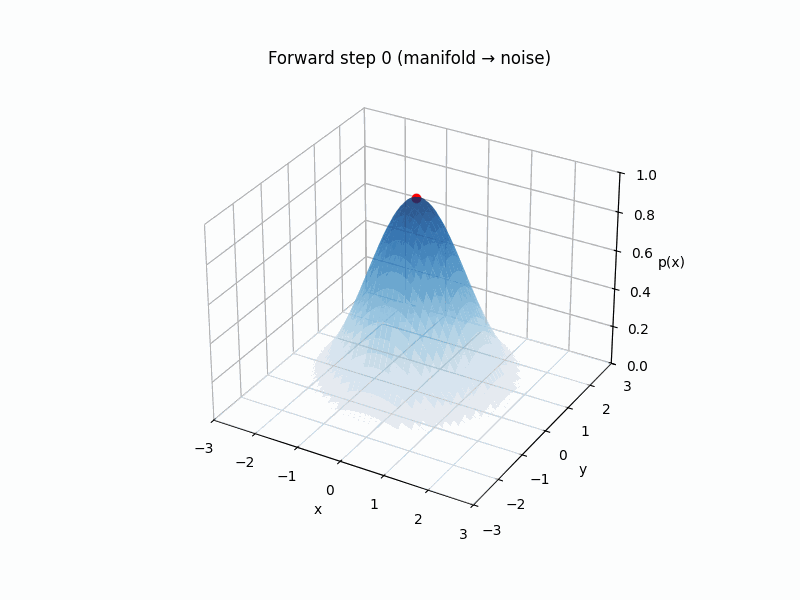

In [ ]:
# Gerar GIF do forward em 3D
filenames = []
for i, pt in enumerate(trajectory_forward):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='Blues', alpha=0.6)  # superfície da densidade
    traj = np.array(trajectory_forward[:i+1])
    ax.plot(traj[:,0], traj[:,1], np.exp(log_p(traj[:,0], traj[:,1])), color='red', marker='o')
    ax.set_title(f"Forward step {i} (manifold → noise)")
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.set_zlim(0,1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('p(x)')
    fname = f"forward3d_{i}.png"
    plt.savefig(fname)
    plt.close()
    filenames.append(fname)

# Criar GIF animado do processo forward
with imageio.get_writer("forward_process_3d.gif", mode="I", duration=0.2, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

from IPython.display import Image, display
display(Image(filename="forward_process_3d.gif"))

**Reverse (noise → manifold)**: o ponto começa longe, no meio do ruído, e é gradualmente puxado pelo score function para o centro (região de dados plausíveis), subindo o morro da densidade.

In [ ]:
# Agora começamos longe do centro (puro ruído)
point = np.array([2.5, -2.0])
trajectory_reverse = [point.copy()]

eta = 0.1  # tamanho do passo para seguir o gradiente
# A cada passo, vamos corrigindo na direção do score → reduz entropia → volta ao manifold
for _ in range(steps):
    dx, dy = score(point[0], point[1])  # gradiente aponta para o centro
    point += eta * np.array([dx, dy])
    trajectory_reverse.append(point.copy())

In [ ]:
trajectory_reverse

[array([ 2.5, -2. ]),
 array([ 2.25, -1.8 ]),
 array([ 2.025, -1.62 ]),
 array([ 1.8225, -1.458 ]),
 array([ 1.64025, -1.3122 ]),
 array([ 1.476225, -1.18098 ]),
 array([ 1.3286025, -1.062882 ]),
 array([ 1.19574225, -0.9565938 ]),
 array([ 1.07616802, -0.86093442]),
 array([ 0.96855122, -0.77484098]),
 array([ 0.8716961 , -0.69735688]),
 array([ 0.78452649, -0.62762119]),
 array([ 0.70607384, -0.56485907]),
 array([ 0.63546646, -0.50837317]),
 array([ 0.57191981, -0.45753585]),
 array([ 0.51472783, -0.41178226]),
 array([ 0.46325505, -0.37060404]),
 array([ 0.41692954, -0.33354363]),
 array([ 0.37523659, -0.30018927]),
 array([ 0.33771293, -0.27017034]),
 array([ 0.30394164, -0.24315331]),
 array([ 0.27354747, -0.21883798]),
 array([ 0.24619273, -0.19695418]),
 array([ 0.22157345, -0.17725876]),
 array([ 0.19941611, -0.15953289]),
 array([ 0.1794745, -0.1435796]),
 array([ 0.16152705, -0.12922164]),
 array([ 0.14537434, -0.11629947]),
 array([ 0.13083691, -0.10466953]),
 array([ 0.117

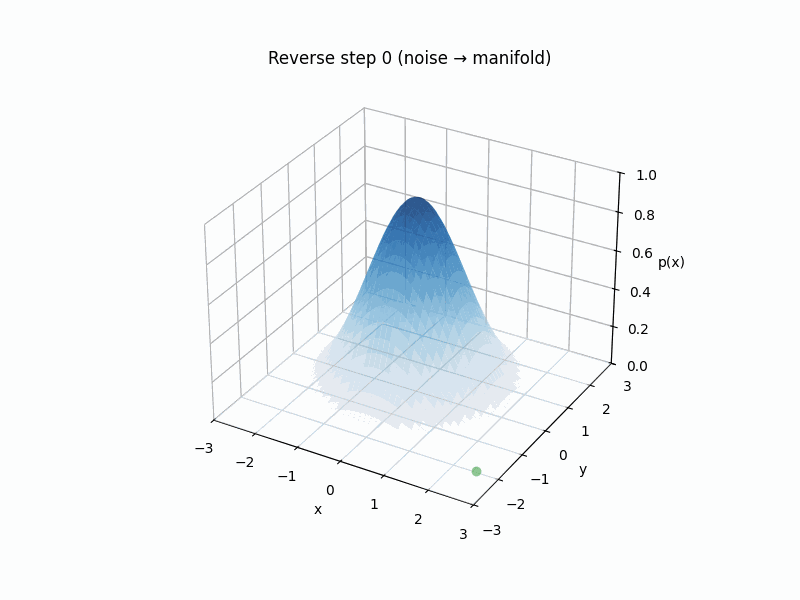

In [ ]:
# Gerar GIF do reverse em 3D
filenames = []
for i, pt in enumerate(trajectory_reverse):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='Blues', alpha=0.6)
    traj = np.array(trajectory_reverse[:i+1])
    ax.plot(traj[:,0], traj[:,1], np.exp(log_p(traj[:,0], traj[:,1])), color='green', marker='o')
    ax.set_title(f"Reverse step {i} (noise → manifold)")
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.set_zlim(0,1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('p(x)')
    fname = f"reverse3d_{i}.png"
    plt.savefig(fname)
    plt.close()
    filenames.append(fname)

with imageio.get_writer("reverse_process_3d.gif", mode="I", duration=0.2, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

display(Image(filename="reverse_process_3d.gif"))